## 추천시스템 분석 입문하기 3강 - 컨텐츠 기반모델 - Word2Vec

출처 : https://www.youtube.com/watch?v=3jfHP0Rq1Gg&list=PL9mhQYIlKEhdkOVTZWJJIy8rv6rQaZNNc&index=3

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

In [3]:
import warnings
warnings.filterwarnings(action = 'ignore')

##### 간단한 word2vec 구현해보기
sentence = you say goodbye and I say hello

CBOW 과정. say를 학습하기

In [10]:
# 원핫 형태의 입력값을 win과 곱

input1 = np.array([[1,0,0,0,0,0,0]]) # you
input2 = np.array([[0,0,1,0,0,0,0]]) # goodbye

In [11]:
# (입력 x 차원의 크기) - 차원의 크기는 하이퍼파라미터. 5차원으로 해보자!
# 초기 weight는 랜덤값
W_in = np.random.randn(7,5)

In [12]:
#은닉층의 값
h_1 = np.matmul(input1, W_in)
h_2 = np.matmul(input2, W_in)

In [13]:
print((h_1+h_2)/2)

[[0.06942125 0.54353895 0.13643647 1.08803196 0.39629566]]


In [15]:
# hidden state의 값을 W_out과 곱해서 Score를 추출한다
# Score에 Softmax를 취해서 각 단어가 나올 확률을 계산한다.

h = (h_1+h_2)/2
W_out = np.random.randn(5,7)
score = np.matmul(h,W_out)
print(np.round(score,4))

[[ 0.0764 -0.0314  1.4682 -0.3266 -0.427   0.1505 -2.3006]]


In [16]:
# soft max define

def softmax(x):
    exp_x = np.exp(x)
    sum_exp_x = np.sum(exp_x)
    y = exp_x / sum_exp_x
    return y

In [18]:
pred = softmax(score)
print(np.round(pred,4))

[[0.1196 0.1074 0.481  0.0799 0.0723 0.1288 0.0111]]


In [21]:
# 정답과 cross entropy loss를 계산해준다

# cross entropy define
def cross_entropy_loss(y, t):
        '''
        y : prediction
        t = target
        '''
        delta = 1e-7 # log의 내부가 0이되는것을 방지(스무딩?)
        
        # y.shpae[0]으로 나눠주는 이유는 배치 사이즈 반영
        return -np.sum(t + np.log(y + delta)) / y.shape[0]

In [22]:
cross_entropy_loss(pred, [0,1,0,0,0,0,0])

15.79148245939156

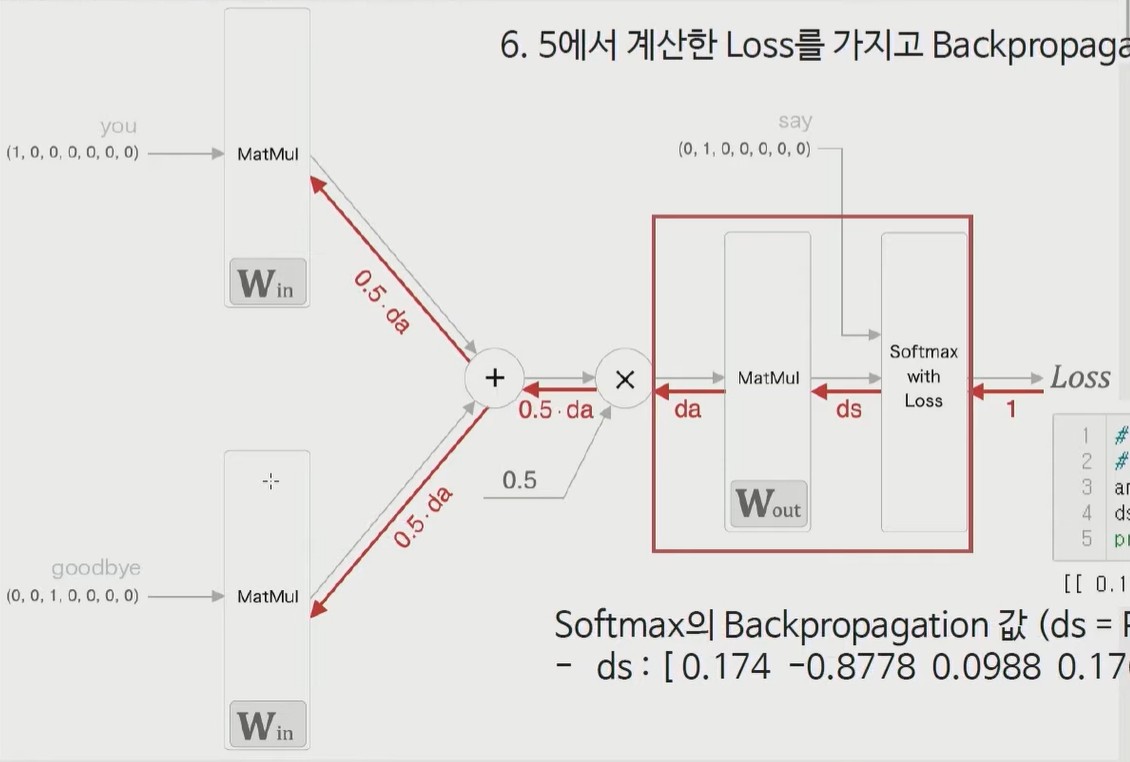

In [24]:
# 계산한 loss를 가지고 BP를 통해 weight를 업데이트
# softmax의 미분값

ans = [0,1,0,0,0,0,0]
ds = np.round(pred - ans, 4)
print(ds)
# ds = Pi - yi

[[ 0.1196 -0.8926  0.481   0.0799  0.0723  0.1288  0.0111]]


In [25]:
# ds(Delta for W_out) 계산
dW_out = np.outer(h, ds)
print(np.round(dW_out,4))

[[ 8.300e-03 -6.200e-02  3.340e-02  5.500e-03  5.000e-03  8.900e-03
   8.000e-04]
 [ 6.500e-02 -4.852e-01  2.614e-01  4.340e-02  3.930e-02  7.000e-02
   6.000e-03]
 [ 1.630e-02 -1.218e-01  6.560e-02  1.090e-02  9.900e-03  1.760e-02
   1.500e-03]
 [ 1.301e-01 -9.712e-01  5.233e-01  8.690e-02  7.870e-02  1.401e-01
   1.210e-02]
 [ 4.740e-02 -3.537e-01  1.906e-01  3.170e-02  2.870e-02  5.100e-02
   4.400e-03]]


In [26]:
# 계산한 loss를 가지고 BP 과정을 통해서  Weight를 업데이트
# W_in_new = W_in - lr*dw-in
da = np.dot(ds, W_out.T)
print(np.round(da, 4))

[[-0.9261  0.1179 -1.0947  1.4162 -1.7945]]


In [27]:
dw_1 = np.round(np.outer(np.array([[1,0,0,0,0,0,0]]), (da/2)), 4)
print(dw_1)

[[-0.463   0.059  -0.5473  0.7081 -0.8972]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]]


In [29]:
dw_2 = np.round(np.outer(np.array([[0,0,1,0,0,0,0]]), (da/2)), 4)
print(dw_2)

[[-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.463   0.059  -0.5473  0.7081 -0.8972]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]
 [-0.      0.     -0.      0.     -0.    ]]


위 과정을 계속 실행해주면된다!

----------

skip-gram의 경우 하나의 인풋(say)을 받아서 두가지 아웃풋(you, goodbye)이 나오는구조

1. 원핫 벡터 형태의 입력값을 받는다
    - say -> you 예측
    - say - > goodbye 예측
        - 주변단어 : 주변에 있는 단어 (you, goodbye)
        - 중심단어 : 중간에 있는 단어 (say)
        - 윈도우 크기 : 주변을 몇 칸으로 볼 건지에 대한 크기(1) / 만약 윈도우가 2면 say를 통해 you, goodbye, and를 예측

2. 원핫 벡터 형태의 입력값을 Win과 곱

In [30]:
input = np.array([[0,1,0,0,0,0,0]]) # say

output1 = np.array([[1,0,0,0,0,0,0]]) # you
output2 = np.array([[0,0,1,0,0,0,0]]) # goodbye

In [32]:
# (입력 * 차원의 크기) - 차원의 크기는 하이퍼파라미터
## 초기의 weight는 랜덤값으로(5)
W_in = np.random.randn(7,5)
h = np.matmul(input, W_in) # 은닉층 값
print(h)

[[-0.36339093 -1.11421756 -0.16640151 -0.64067307  1.09727876]]


3. Hiddem state의 값을 W_out과 곱해서 Score를 추출

4. Score에 Softmax를 취해서 각 단어가 나올 확률을 계산한다.

In [33]:
W_out = np.random.randn(5,7)
score = np.matmul(h,W_out)
print(np.round(score, 4))

[[ 1.04   -0.4892 -0.0271 -0.0884 -2.1197 -1.7835  2.1477]]


In [34]:
pred = softmax(score)
print(np.round(pred, 4))

[[0.1995 0.0432 0.0686 0.0645 0.0085 0.0118 0.6038]]


5. 정답과 Cross Entropy Loss 계산

6. 5에서 계산한 loss를 가지고 BP 과정을 통해서 weight를 업데이트
    - 두 개의 answer에 대해서 오차를 더함

In [35]:
ds1 = np.round(pred - output1, 4)
ds2 = np.round(pred - output2, 4)
ds = ds1 + ds2
print(ds)

[[-0.601   0.0864 -0.8628  0.129   0.017   0.0236  1.2076]]


In [36]:
dw_out = np.round(np.outer(h, ds), 4)
print(dw_out)

[[ 0.2184 -0.0314  0.3135 -0.0469 -0.0062 -0.0086 -0.4388]
 [ 0.6696 -0.0963  0.9613 -0.1437 -0.0189 -0.0263 -1.3455]
 [ 0.1    -0.0144  0.1436 -0.0215 -0.0028 -0.0039 -0.2009]
 [ 0.385  -0.0554  0.5528 -0.0826 -0.0109 -0.0151 -0.7737]
 [-0.6595  0.0948 -0.9467  0.1415  0.0187  0.0259  1.3251]]


In [37]:
da = np.dot(ds, W_out.T)
print(np.round(da,4))

[[-0.8243 -1.3708 -1.5986  1.3268  0.5624]]


In [38]:
dw_in = np.outer(np.array([[0,1,0,0,0,0,0]]), da)
print(dw_in)

[[-0.         -0.         -0.          0.          0.        ]
 [-0.82428045 -1.3708162  -1.59860768  1.32675672  0.56244677]
 [-0.         -0.         -0.          0.          0.        ]
 [-0.         -0.         -0.          0.          0.        ]
 [-0.         -0.         -0.          0.          0.        ]
 [-0.         -0.         -0.          0.          0.        ]
 [-0.         -0.         -0.          0.          0.        ]]


W_in에 대해서 update진행

In [39]:
learning_rate = 1
W_in_new = W_in - learning_rate + dw_in
print(np.round(W_in_new, 4))

[[ 0.6145 -2.294  -1.2131  0.6228 -0.7726]
 [-2.1877 -3.485  -2.765  -0.3139  0.6597]
 [-2.4528 -1.8798 -1.5406  0.3581 -0.9577]
 [-0.7254 -0.96   -1.3202 -1.9716 -1.8124]
 [-1.4549  0.2048 -0.2678  2.4844 -0.6415]
 [-0.9126 -1.2028 -1.3537 -2.33   -1.2697]
 [-0.7484  0.3152 -2.5168  0.636  -0.7781]]


In [40]:
print(np.round(W_in, 4))

[[ 1.6145 -1.294  -0.2131  1.6228  0.2274]
 [-0.3634 -1.1142 -0.1664 -0.6407  1.0973]
 [-1.4528 -0.8798 -0.5406  1.3581  0.0423]
 [ 0.2746  0.04   -0.3202 -0.9716 -0.8124]
 [-0.4549  1.2048  0.7322  3.4844  0.3585]
 [ 0.0874 -0.2028 -0.3537 -1.33   -0.2697]
 [ 0.2516  1.3152 -1.5168  1.636   0.2219]]


W_out에 대해서 update 진행

In [44]:
learning_rate = 1
W_out_new = W_out - learning_rate + dw_out
print(np.round(W_out_new, 4))

[[-2.5675 -2.1297 -0.5707 -1.5226 -0.1517  0.1811 -2.8334]
 [ 0.9662 -0.1    -1.0111 -2.6618  0.9704 -0.5335 -3.4768]
 [ 0.1131 -0.1451 -0.552  -0.9084 -0.1665 -0.3593 -1.9016]
 [-0.0091 -0.2369 -0.4149 -0.8153 -0.4883 -0.7341 -0.4504]
 [ 0.5209 -0.0933 -2.8554 -2.4649 -0.1781 -1.4433  1.3381]]


In [45]:
print(np.round(W_out, 4))

[[-1.7859 -1.0983  0.1158 -0.4757  0.8545  1.1897 -1.3946]
 [ 1.2966  0.9963 -0.9724 -1.5181  1.9893  0.4928 -1.1313]
 [ 1.0131  0.8693  0.3044  0.1131  0.8363  0.6446 -0.7007]
 [ 0.6059  0.8185  0.0323  0.2673  0.5226  0.281   1.3233]
 [ 2.1804  0.8119 -0.9087 -1.6064  0.8032 -0.4692  1.013 ]]


위 과정을 다른 문맥에 대해서도 수행!